# Radius-height cross-sections of TC Debbie

**Mar 31, 2022**

Creating these cross-sections requires us to:
1. Find the centre of the cyclone at a particular point in time
2. Convert from Cartesian to polar coordinates (including the winds to radial/tangential winds)
3. Take an azimuthal mean around the centre defined in step 1.

Cross-sections are done on model level heights rather than absolute heights. This is because vertical interpolation/conversion to height coordinates is computationally expensive. Over the ocean this should be insigificant, though there may be some differences near the surface over mountains. 

Some of the algorithms in this notebook are quite inefficient at the moment (especially the azimuthal mean). Therefore we're just using the 2.2 km dataset here rather than the full 400 m data.

## Setup

In [1]:
# import aus400 module
import sys
sys.path.append('Documents/aus400/aus400-cookbook/')
import aus400

# other modules
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
import dask.diagnostics
from dask.distributed import Client, LocalCluster, Scheduler
import pandas as pd

**Setup a dask cluster:**

Depending on the size of the domain and/or resolution, it may be more useful to use OOD's cloud nodes (SLURM cluster).

I have found that the performance isn't that much greater with the SLURM cluster (perhaps because a lot of time is spent in loops rather than being parallelised)

In [2]:
try:
    client
except:
    cluster = LocalCluster()
    client = Client(cluster)

# from dask_jobqueue import SLURMCluster
# try:
#     client
# except:
#     cluster = SLURMCluster(cores=16,memory="31GB")
#     client = Client(cluster)
#     cluster.scale(cores=32)

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 11.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41347,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 11.23 GiB
Comm: tcp://127.0.0.1:45093,Total threads: 1
Dashboard: /proxy/41405/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:41389,


**Data options:**

In [4]:
res = 'd0198'
time = '2017-03-27T12:00'

# region to plot
[[min_lon, max_lon], [min_lat, max_lat]] = [[145.0, 152.0], [-22.5,  -15.5]]

## Load and subset the data

In [5]:
wnd_ucmp = aus400.cat.load_var(ensemble=0, resolution=res, stream='mdl', variable='wnd_ucmp', time=time)
wnd_ucmp = wnd_ucmp.sel({'longitude': slice(min_lon, max_lon), 'latitude': slice(min_lat, max_lat)})
wnd_ucmp = wnd_ucmp.isel(time=0).squeeze()

wnd_vcmp = aus400.cat.load_var(ensemble=0, resolution=res, stream='mdl', variable='wnd_vcmp', time=time)
wnd_vcmp = wnd_vcmp.sel({'longitude': slice(min_lon, max_lon), 'latitude': slice(min_lat, max_lat)})
wnd_vcmp = wnd_vcmp.isel(time=0).squeeze()

mslp = aus400.cat.load_var(ensemble=0, resolution=res, stream='spec', variable='mslp', time=time)
mslp = mslp.sel({'longitude': slice(min_lon, max_lon), 'latitude': slice(min_lat, max_lat)})
mslp = mslp.isel(time=0).squeeze()
mslp = mslp.compute() # mslp must be loaded for the tracking algorithm to work properly 

theta = aus400.cat.load_var(ensemble=0, resolution=res, stream='mdl', variable='theta', time=time)
theta = theta.sel({'longitude': slice(min_lon, max_lon), 'latitude': slice(min_lat, max_lat)})
theta = theta.isel(time=0).squeeze()

vert_wnd = aus400.cat.load_var(ensemble=0, resolution=res, stream='mdl', variable='vertical_wnd', time=time)
vert_wnd = vert_wnd.sel({'longitude': slice(min_lon, max_lon), 'latitude': slice(min_lat, max_lat)})
vert_wnd = vert_wnd.isel(time=0).squeeze()

**Convert u/v to scalar grid**

In [6]:
%%time
wnd_ucmp = aus400.regrid.regrid_vector(wnd_ucmp)
wnd_vcmp = aus400.regrid.regrid_vector(wnd_vcmp)

# ensure all data has the same size and coorindates (sometimess they seem slightly different for some reason?)
wnd_ucmp, wnd_vcmp = xr.align(wnd_ucmp, wnd_vcmp)
wnd_ucmp = wnd_ucmp.reindex_like(theta, method='nearest')
wnd_vcmp = wnd_vcmp.reindex_like(theta, method='nearest')

CPU times: user 211 ms, sys: 28.5 ms, total: 240 ms
Wall time: 339 ms


## Convert u/v to polar coordinates

**Find the centre of the cyclone:**

See `aus400.calc` for more information on how this is done. 

In [7]:
%%time
centre_pos = aus400.calc.cyclone_centre(mslp)
centre_pos

CPU times: user 34.8 ms, sys: 4.5 ms, total: 39.3 ms
Wall time: 41.7 ms


<xarray.DataArray 'mslp' ()>
array(93862.54, dtype=float32)
Coordinates:
    time                     datetime64[ns] 2017-03-27T12:10:00
    latitude                 float32 -19.01
    longitude                float32 148.8
    forecast_reference_time  datetime64[ns] 2017-03-27T06:00:00
    forecast_period          timedelta64[ns] 06:10:00.000001200
    ensemble                 int64 0
Attributes:
    standard_name:           air_pressure_at_sea_level
    units:                   Pa
    source:                  Data from Met Office Unified Model
    um_version:              11.4
    STASH:                   [  1  16 222]
    um_stash_source:         m01s16i222
    long_name:               PRESSURE AT MEAN SEA LEVEL
    stash_code:              16222
    wgdos_packing_accuracy:  2^0
    description:             Atmospheric pressure at mean sea level.
    resolution:              d0198
    stream:                  spec

**Calculate radial and tangential velocities, & relative vorticity:**

The formulae are

Radial velocity: $v_r = u \cos{\theta} + v \sin{\theta}$

Tangential velocity: $v_\theta = v \cos{\theta} - u \sin{\theta}$

where $\theta$ is the angle between the line from the centre to the grid point and the x-axis. This is implemented in `aus400.calc`.

In [8]:
%%time
rad_wnd, tan_wnd = aus400.calc.winds_to_polar(wnd_ucmp, wnd_vcmp, centre_pos)
rv = aus400.calc.rel_vort(wnd_ucmp, wnd_vcmp)

CPU times: user 3.07 s, sys: 302 ms, total: 3.37 s
Wall time: 5.93 s


**Quick visualisation of how these look on the first model level:**

The winds should be primarily inward ($v_r < 0$) and clockwise ($v_\theta < 0$), which is consistent with the winds below.

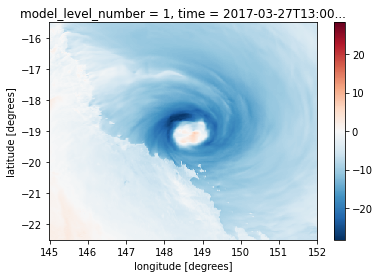

In [9]:
rad_wnd.sel(model_level_number=1).plot()

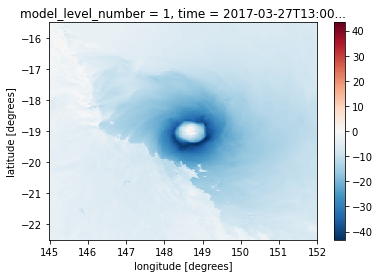

In [10]:
tan_wnd.sel(model_level_number=1).plot()

## Construct the azimuthal mean

This is the tricky part! As far as I'm aware, there is no simple way to calculate an azimuthal average from a Cartesian grid.

The idea here is to calculate the distance/radius from the central point to all other points in the grid. Then we round this to 0.01 degrees and take the average over each radius "interval". This approximates an average over "rings" of increasing r, with similar radii being grouped together.

In [11]:
# add r/theta coords to the data. Radius is rounded to the nearest 0.01 deg (see dervied_vars.py)
tan_wnd = aus400.calc.cart_to_pol(tan_wnd, centre_pos)
rad_wnd = aus400.calc.cart_to_pol(rad_wnd, centre_pos)
theta = aus400.calc.cart_to_pol(theta, centre_pos)
vert_wnd = aus400.calc.cart_to_pol(vert_wnd, centre_pos)
rv = aus400.calc.cart_to_pol(rv, centre_pos)

In [12]:
# create a list of radii
r_list = np.unique(rv.r)
r_list = np.reshape(r_list, -1)
r_list.sort()

# maximum radius before we hit the edge of the box (otherwise max radius set to 3 degrees)
max_r = min(abs(max_lat - centre_pos['latitude']),
           abs(min_lat - centre_pos['latitude']),
           abs(max_lat - centre_pos['latitude']),
           abs(min_lat - centre_pos['latitude'])).values
max_r = min(3, max_r)

r_list = r_list[r_list < max_r]

**Calculate the azimuthal mean:**

This is done by iterating over the radius list above. This is pretty inefficient, though loading the data into memory first helps greatly.

In [13]:
%%time
tan_wnd = tan_wnd.compute()
rad_wnd = rad_wnd.compute()
theta = theta.compute()
vert_wnd = vert_wnd.compute()
rv = rv.compute()

CPU times: user 24.3 s, sys: 3.99 s, total: 28.3 s
Wall time: 55.5 s


**Tangential wind**

In [14]:
%%time
tan_wnd_cs = np.zeros((r_list.size, wnd_ucmp.model_level_number.size)) # setting up the cross-section

for i in range(len(r_list)):
    
    tan_wnd2 = tan_wnd.where(tan_wnd.r == r_list[i])
    tan_wnd_cs[i,:] = tan_wnd2.mean(['latitude', 'longitude']).values

CPU times: user 37.8 s, sys: 13 s, total: 50.8 s
Wall time: 52.2 s


CPU times: user 88.9 ms, sys: 11.8 ms, total: 101 ms
Wall time: 102 ms


Text(0.5, 1.0, 'TC Debbie tangential wind: 2017-03-27T13:00:00')

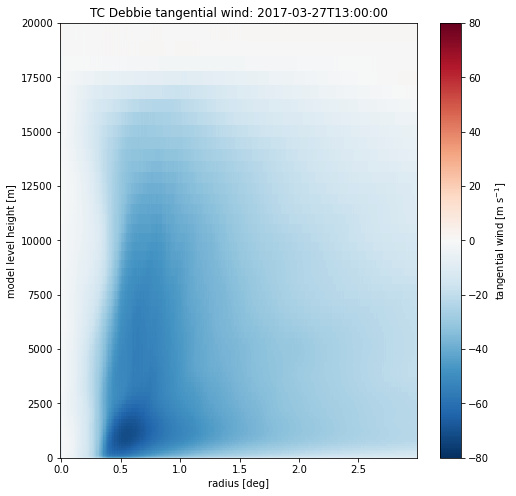

In [15]:
%%time
plt.figure(figsize=(8,8))
[r, level] = np.meshgrid(r_list, tan_wnd.level_height, indexing='ij')

quad = plt.pcolormesh(r, level, tan_wnd_cs, vmin=-80, vmax=80, cmap = 'RdBu_r', shading='auto')
cb = plt.colorbar(quad)
plt.ylim((0, 20000))

plt.xlabel('radius [deg]')
plt.ylabel('model level height [m]')

date_format = str(wnd_ucmp.time.values)[:19]
cb.set_label(r'tangential wind [m s$^{-1}$]')
plt.title(f'TC Debbie tangential wind: {date_format}')

**Radial wind**

In [16]:
%%time
rad_wnd_cs = np.zeros((r_list.size, wnd_ucmp.model_level_number.size)) # setting up the cross-section

for i in range(len(r_list)):
    
    rad_wnd2 = rad_wnd.where(rad_wnd.r == r_list[i])
    rad_wnd_cs[i,:] = rad_wnd2.mean(['latitude', 'longitude']).values

CPU times: user 41.7 s, sys: 13.9 s, total: 55.6 s
Wall time: 52.3 s


CPU times: user 84.1 ms, sys: 5.21 ms, total: 89.3 ms
Wall time: 89.6 ms


Text(0.5, 1.0, 'TC Debbie radial wind: 2017-03-27T13:00:00')

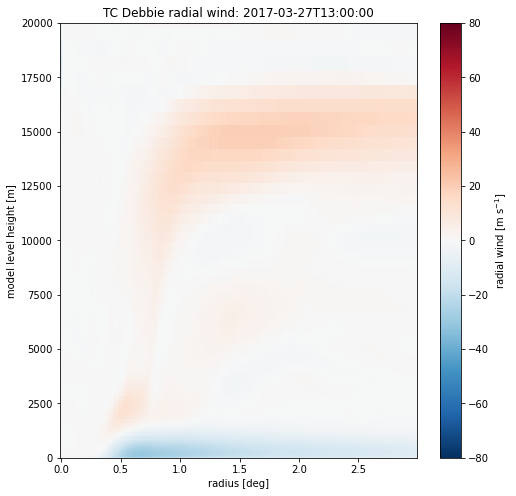

In [17]:
%%time
plt.figure(figsize=(8,8))
[r, level] = np.meshgrid(r_list, rad_wnd.level_height, indexing='ij')

quad = plt.pcolormesh(r, level, rad_wnd_cs, vmin=-80, vmax=80, cmap = 'RdBu_r', shading='auto')
cb = plt.colorbar(quad)
plt.ylim((0, 20000))

plt.xlabel('radius [deg]')
plt.ylabel('model level height [m]')

date_format = str(wnd_ucmp.time.values)[:19]
cb.set_label(r'radial wind [m s$^{-1}$]')
plt.title(f'TC Debbie radial wind: {date_format}')

**Potential temperature**

In [18]:
%%time
theta_cs = np.zeros((r_list.size, theta.model_level_number.size)) # setting up the cross-section

for i in range(len(r_list)):
    
    theta2 = theta.where(theta.r == r_list[i])
    theta_cs[i,:] = theta2.mean(['latitude', 'longitude']).values

CPU times: user 29.6 s, sys: 7.2 s, total: 36.8 s
Wall time: 34.7 s


CPU times: user 81.2 ms, sys: 6.16 ms, total: 87.4 ms
Wall time: 84.2 ms


Text(0.5, 1.0, 'TC Debbie potential temperature: 2017-03-27T13:00:00')

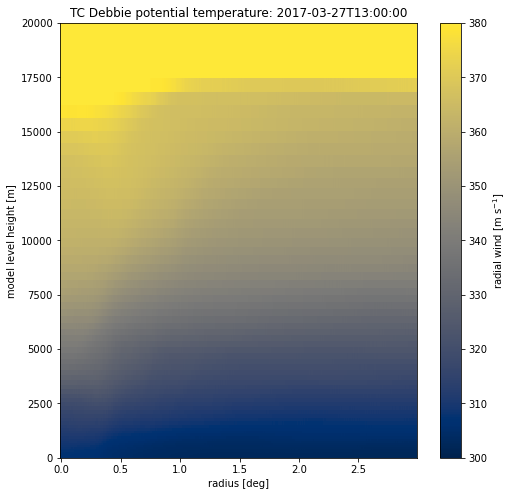

In [19]:
%%time
plt.figure(figsize=(8,8))
[r, level] = np.meshgrid(r_list, theta.level_height, indexing='ij')

quad = plt.pcolormesh(r, level, theta_cs, vmin=300, vmax=380, cmap = 'cividis', shading='auto')
cb = plt.colorbar(quad)
plt.ylim((0, 20000))

plt.xlabel('radius [deg]')
plt.ylabel('model level height [m]')

date_format = str(wnd_ucmp.time.values)[:19]
cb.set_label(r'radial wind [m s$^{-1}$]')
plt.title(f'TC Debbie potential temperature: {date_format}')

**Vertical wind**

In [20]:
%%time
vert_wnd_cs = np.zeros((r_list.size, vert_wnd.model_level_number.size)) # setting up the cross-section

for i in range(len(r_list)):
    
    vert_wnd2 = vert_wnd.where(vert_wnd.r == r_list[i])
    vert_wnd_cs[i,:] = vert_wnd2.mean(['latitude', 'longitude']).values

CPU times: user 28.8 s, sys: 7.94 s, total: 36.7 s
Wall time: 34.7 s


CPU times: user 76.3 ms, sys: 14.6 ms, total: 90.9 ms
Wall time: 93.7 ms


Text(0.5, 1.0, 'TC Debbie vertical wind: 2017-03-27T13:00:00')

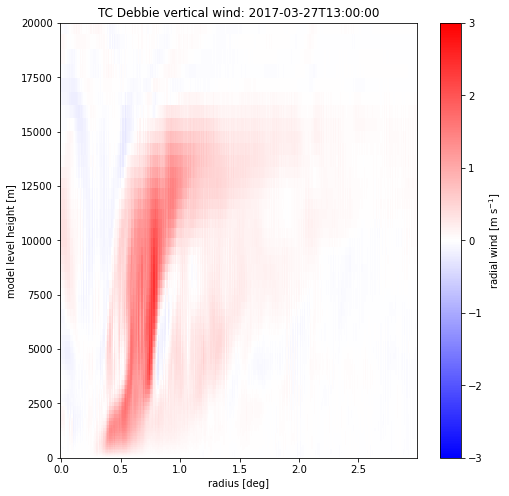

In [21]:
%%time
plt.figure(figsize=(8,8))
[r, level] = np.meshgrid(r_list, vert_wnd.level_height, indexing='ij')

quad = plt.pcolormesh(r, level, vert_wnd_cs, vmin=-3, vmax=3, cmap = 'bwr', shading='auto')
cb = plt.colorbar(quad)
plt.ylim((0, 20000))

plt.xlabel('radius [deg]')
plt.ylabel('model level height [m]')

date_format = str(wnd_ucmp.time.values)[:19]
cb.set_label(r'radial wind [m s$^{-1}$]')
plt.title(f'TC Debbie vertical wind: {date_format}')

**Relative vorticity (& tangential wind)**

In [22]:
%%time
rv_cs = np.zeros((r_list.size, rv.model_level_number.size)) # setting up the cross-section

for i in range(len(r_list)):
    
    rv2 = rv.where(rv.r == r_list[i])
    rv_cs[i,:] = rv2.mean(['latitude', 'longitude']).values

CPU times: user 40.9 s, sys: 13.6 s, total: 54.5 s
Wall time: 51.5 s


CPU times: user 109 ms, sys: 11.2 ms, total: 120 ms
Wall time: 128 ms


Text(0.5, 1.0, 'TC Debbie relative vorticity & tangential winds: 2017-03-27T13:00:00')

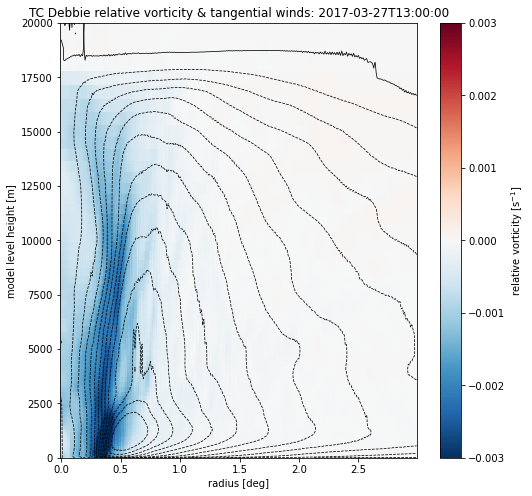

In [23]:
%%time
plt.figure(figsize=(8,8))
[r, level] = np.meshgrid(r_list, rv.level_height, indexing='ij')

quad = plt.pcolormesh(r, level, rv_cs, vmin=-3e-3, vmax=3e-3, cmap = 'RdBu_r', shading='auto')
plt.contour(r, level, tan_wnd_cs, levels = np.arange(-65, 5, 5), colors='k', linewidths=0.75)#, vmin=-80, vmax=80, cmap = 'bwr')
cb = plt.colorbar(quad)
plt.ylim((0, 20000))

plt.xlabel('radius [deg]')
plt.ylabel('model level height [m]')

date_format = str(wnd_ucmp.time.values)[:19]
cb.set_label(r'relative vorticity [s$^{-1}$]')
plt.title(f'TC Debbie relative vorticity & tangential winds: {date_format}')